In [1]:
# !pip install -q git+https://github.com/samoturk/mol2vec;

In [2]:
# !pip install -q huggingface-hub transformers catboost xgboost lightgbm torch gensim==3.7.1

In [3]:
import gensim
print(gensim.__version__) # 3.7.1

3.7.1


In [2]:
from typing import Any, Callable, Dict, Iterable, List, Tuple, Optional, Union
import pandas as pd
import numpy as np
import os
import dgl
import yaml

from rdkit import Chem
from mordred import Calculator, descriptors

from huggingface_hub import snapshot_download
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM

from mol2vec.features import MolSentence, DfVec, sentences2vec, mol2alt_sentence, mol2sentence
from gensim.models import word2vec

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV, LassoCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
import torch

from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

2024-04-20 04:46:21.051963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 04:46:23.017226: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-20 04:46:23.017407: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-20 04:46:23.017421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
from utils import PreprocessSMILES
from utils import SimpleRegressions
from utils import SmallNN
from utils import LstmRegressor


directory = './materials/'
preprocessor = PreprocessSMILES(directory)
mdf = preprocessor.preprocess_data("train_data_fix_concat.csv")
grouped_mdf = preprocessor.preprocess_mol2vec(mdf)
smiles_df = preprocessor.smiles2sentence(mdf)
joined_df = pd.merge(grouped_mdf, smiles_df, on='blend_id', how='inner')
joined_df = preprocessor.embed_smiles(joined_df, 'DeepChem/ChemBERTa-10M-MTR') # ibm/MoLFormer-XL-both-10pct DeepChem/ChemBERTa-10M-MTR
mdf['graphs'] = preprocessor.generate_graphs(mdf)
# graph_df = mdf.copy()
# graph_df.drop(columns=['oil_property_param_title', 'oil_property_param_value', 'mol'], inplace=True)

X, y = preprocessor.xy_split(joined_df, column = 'embeddings')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0a6af3156071d9519e867d695aa265bb393f were not used when initializing RobertaModel: ['norm_std', 'regression.out_proj.weight', 'norm_mean', 'regression.dense.weight', 'regression.out_proj.bias', 'regression.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0

In [4]:
batched_graph = dgl.batch(mdf['graphs'].tolist())
batched_graph

Graph(num_nodes=12584, num_edges=22700,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'type': Scheme(shape=(1,), dtype=torch.float32)})

In [5]:
print(y.shape)
print(X.shape)

(338,)
(338, 384)


Catboost
0:	learn: 0.9671325	test: 0.9931466	best: 0.9931466 (0)	total: 102ms	remaining: 1m 41s
1:	learn: 0.9488733	test: 0.9811492	best: 0.9811492 (1)	total: 137ms	remaining: 1m 8s
2:	learn: 0.9214586	test: 0.9643511	best: 0.9643511 (2)	total: 176ms	remaining: 58.3s
3:	learn: 0.8956097	test: 0.9364527	best: 0.9364527 (3)	total: 202ms	remaining: 50.4s
4:	learn: 0.8723360	test: 0.9201333	best: 0.9201333 (4)	total: 223ms	remaining: 44.3s
5:	learn: 0.8508684	test: 0.8972522	best: 0.8972522 (5)	total: 242ms	remaining: 40.1s
6:	learn: 0.8336294	test: 0.8887996	best: 0.8887996 (6)	total: 261ms	remaining: 37s
7:	learn: 0.8176658	test: 0.8731939	best: 0.8731939 (7)	total: 281ms	remaining: 34.8s
8:	learn: 0.8000139	test: 0.8622637	best: 0.8622637 (8)	total: 300ms	remaining: 33s
9:	learn: 0.7851600	test: 0.8480737	best: 0.8480737 (9)	total: 325ms	remaining: 32.2s
10:	learn: 0.7740345	test: 0.8378083	best: 0.8378083 (10)	total: 347ms	remaining: 31.2s
11:	learn: 0.7600873	test: 0.8260537	best: 0.8

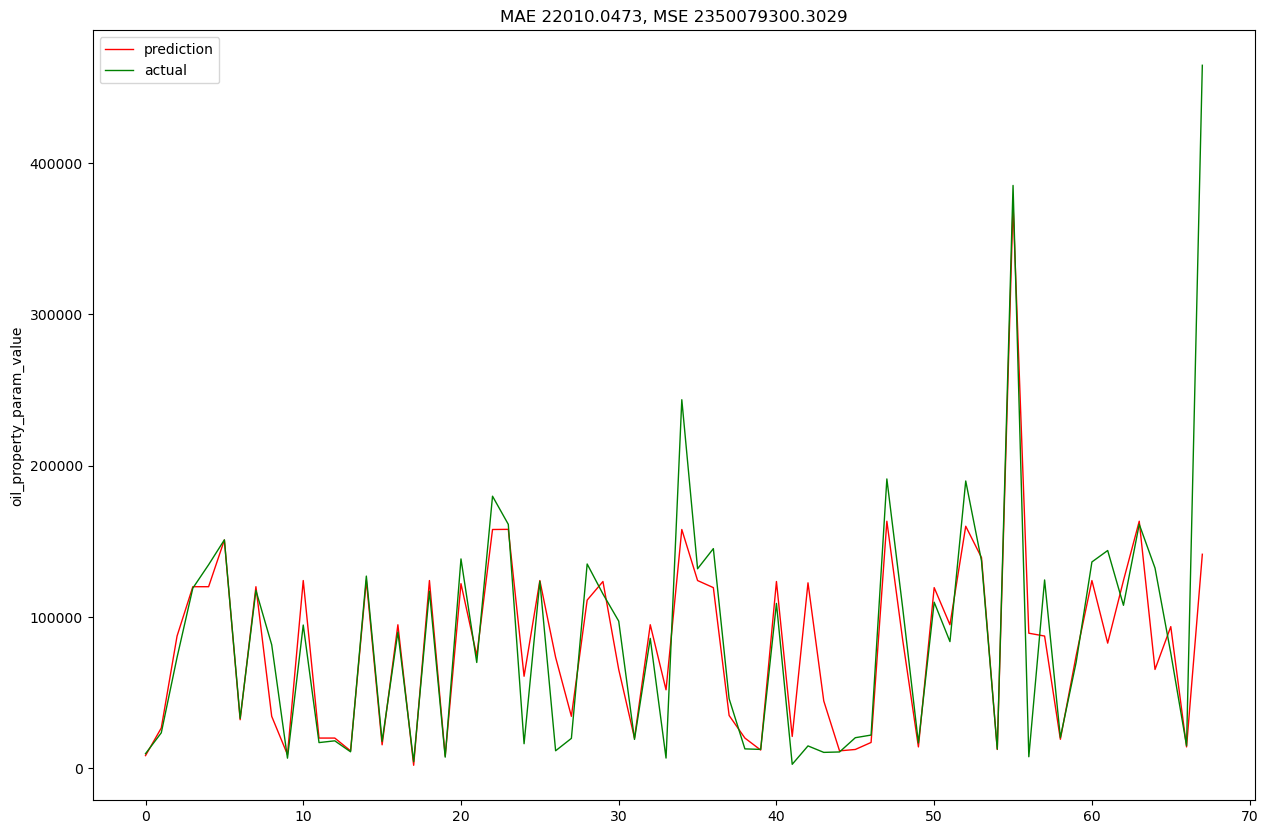

MAE score: 22010.0473
MSE score: 2350079300.3029
RandomForestRegressor


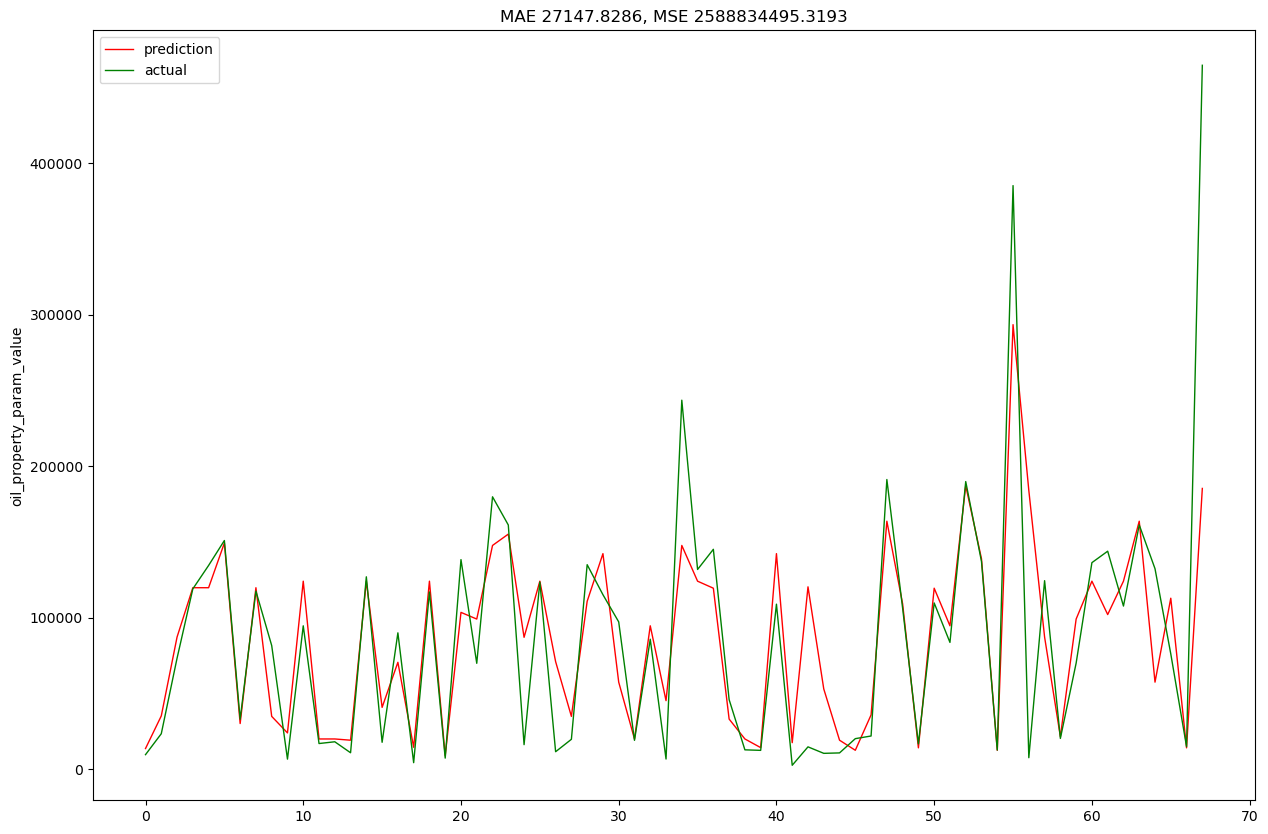

MAE score: 27147.8286
MSE score: 2588834495.3193
XGBRegressor
[0]	validation_0-rmse:1.00433
[1]	validation_0-rmse:0.96116
[2]	validation_0-rmse:0.92448
[3]	validation_0-rmse:0.89497
[4]	validation_0-rmse:0.86848
[5]	validation_0-rmse:0.84752


/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[6]	validation_0-rmse:0.82552
[7]	validation_0-rmse:0.80580
[8]	validation_0-rmse:0.79403
[9]	validation_0-rmse:0.78011
[10]	validation_0-rmse:0.77014
[11]	validation_0-rmse:0.75874
[12]	validation_0-rmse:0.74966
[13]	validation_0-rmse:0.74151
[14]	validation_0-rmse:0.73582
[15]	validation_0-rmse:0.72647
[16]	validation_0-rmse:0.71818
[17]	validation_0-rmse:0.71072
[18]	validation_0-rmse:0.70484
[19]	validation_0-rmse:0.69906
[20]	validation_0-rmse:0.69389
[21]	validation_0-rmse:0.68940
[22]	validation_0-rmse:0.68544
[23]	validation_0-rmse:0.68357
[24]	validation_0-rmse:0.68226
[25]	validation_0-rmse:0.67933
[26]	validation_0-rmse:0.67881
[27]	validation_0-rmse:0.67760
[28]	validation_0-rmse:0.67737
[29]	validation_0-rmse:0.67568
[30]	validation_0-rmse:0.67384
[31]	validation_0-rmse:0.67330
[32]	validation_0-rmse:0.67180
[33]	validation_0-rmse:0.67130
[34]	validation_0-rmse:0.67005
[35]	validation_0-rmse:0.66934
[36]	validation_0-rmse:0.66902
[37]	validation_0-rmse:0.66809
[38]	validat

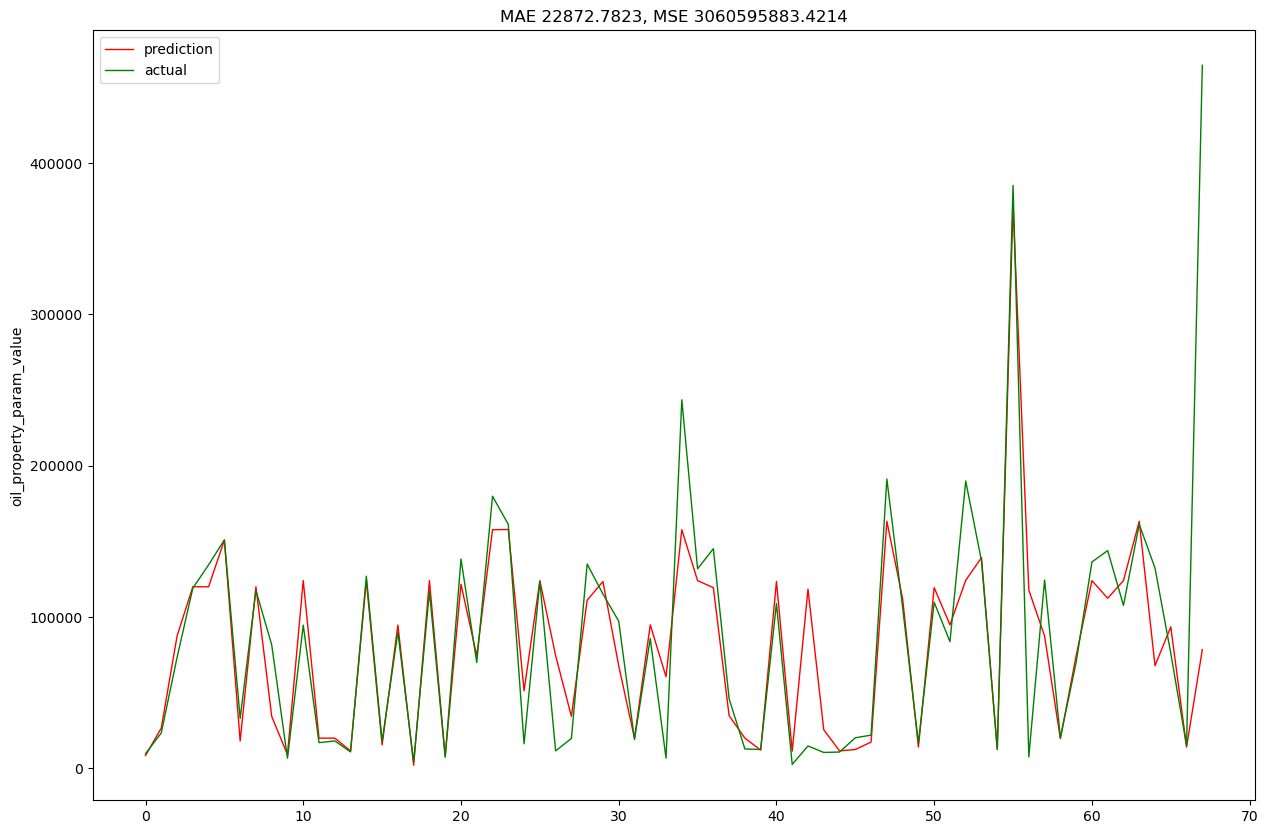

MAE score: 22872.7823
MSE score: 3060595883.4214
LGBMRegressor
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23005
[LightGBM] [Info] Number of data points in the train set: 270, number of used features: 384
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

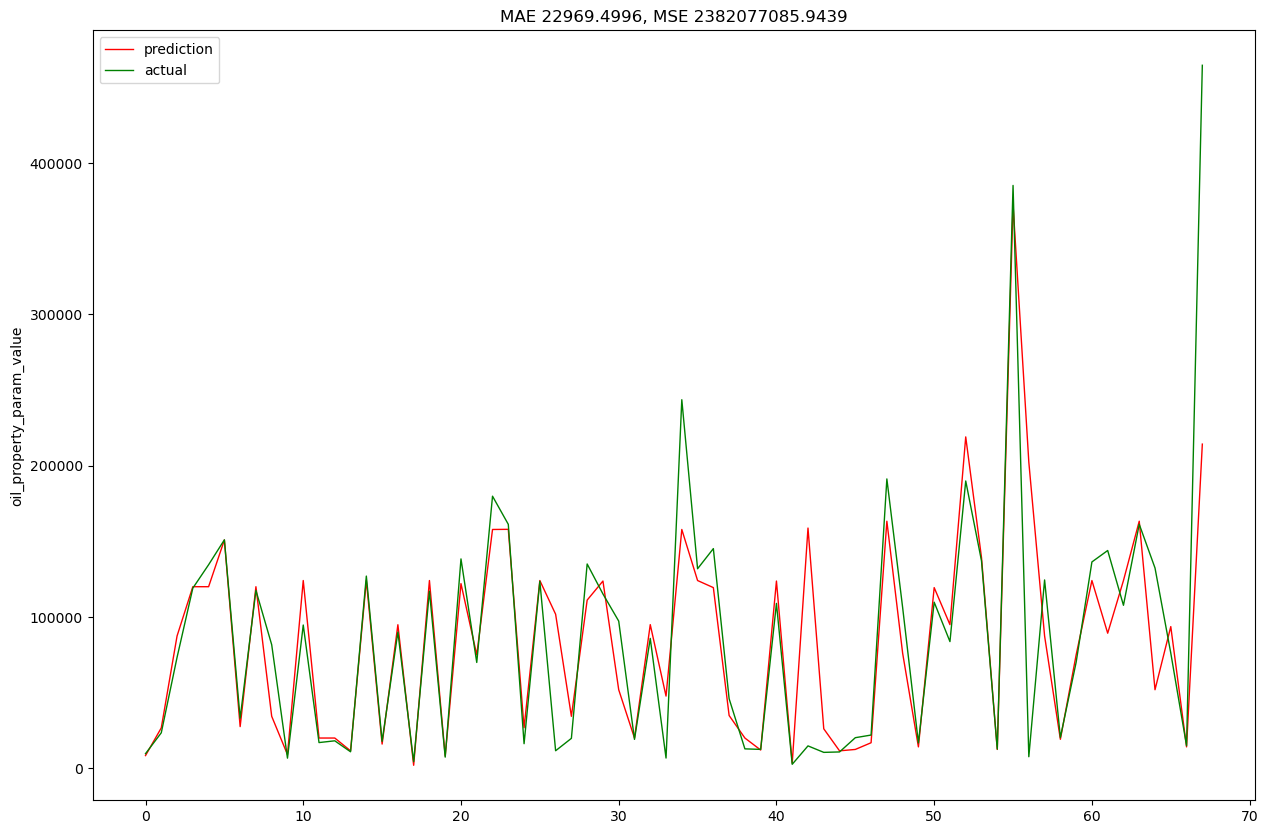

MAE score: 22969.4996
MSE score: 2382077085.9439
GradientBoostingRegressor


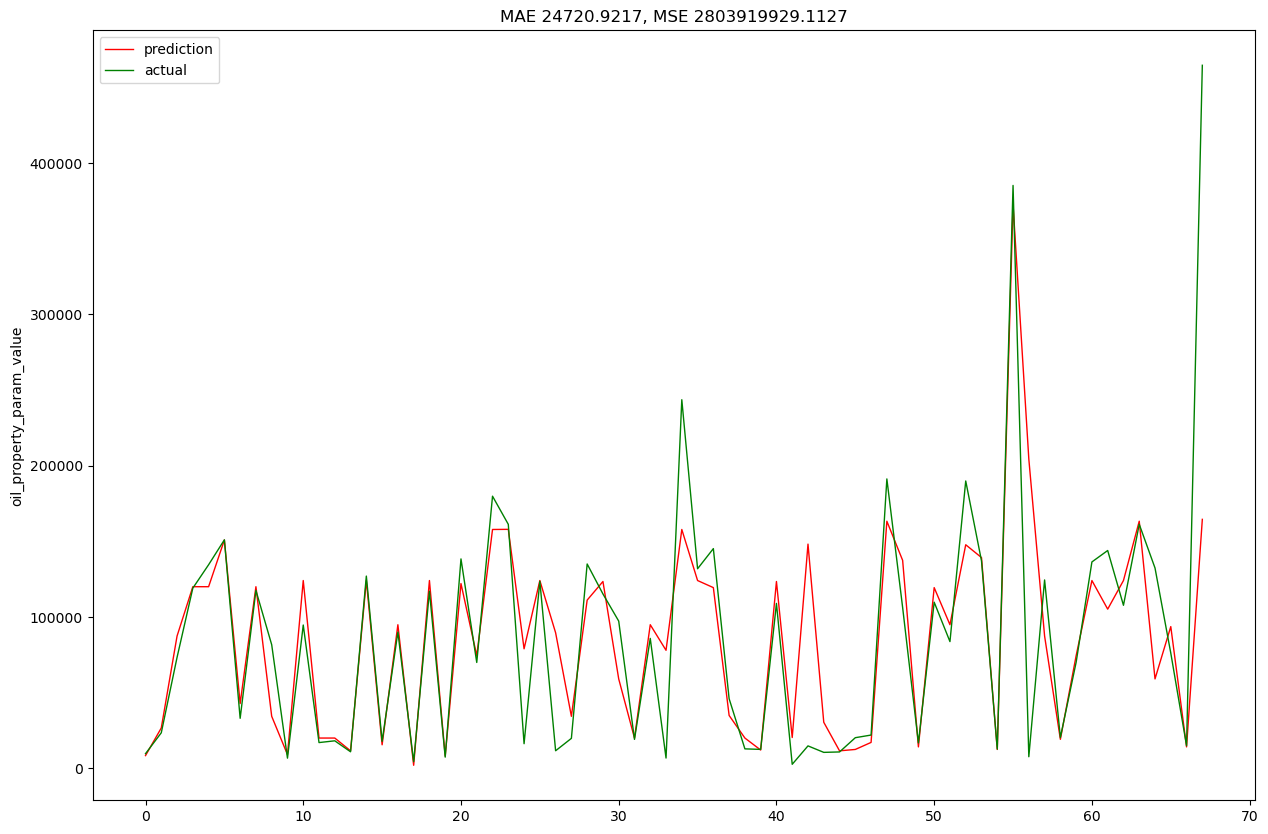

MAE score: 24720.9217
MSE score: 2803919929.1127
SVR


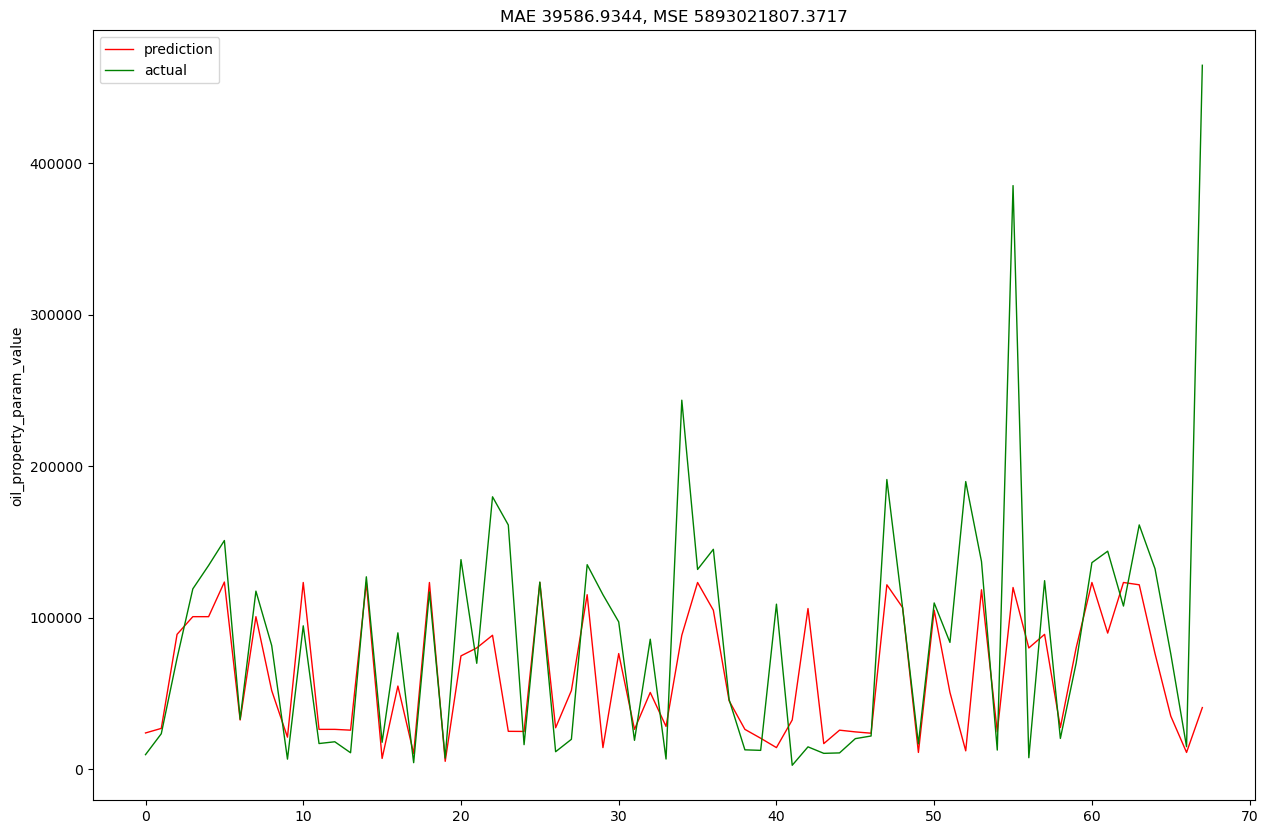

MAE score: 39586.9344
MSE score: 5893021807.3717


In [6]:

regression_models = SimpleRegressions(X, y)
regression_models.fit_and_evaluate()



2024-04-20 04:40:09.070841: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-20 04:40:09.070945: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-20 04:40:09.071360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-HPESRLBL): /proc/driver/nvidia/version does not exist
2024-04-20 04:40:09.073769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/400
4/4 [==============================] - 1s 94ms/step - loss: 0.0142 - mean_absolute_error: 0.0746 - val_loss: 0.0060 - val_mean_absolute_error: 0.0685 - lr: 0.0010
Epoch 2/400
4/4 [==============================] - 0s 24ms/step - loss: 0.0116 - mean_absolute_error: 0.0670 - val_loss: 0.0046 - val_mean_absolute_error: 0.0553 - lr: 0.0010
Epoch 3/400
4/4 [==============================] - 0s 26ms/step - loss: 0.0103 - mean_absolute_error: 0.0574 - val_loss: 0.0049 - val_mean_absolute_error: 0.0547 - lr: 0.0010
Epoch 4/400
4/4 [==============================] - 0s 21ms/step - loss: 0.0099 - mean_absolute_error: 0.0548 - val_loss: 0.0044 - val_mean_absolute_error: 0.0507 - lr: 0.0010
Epoch 5/400
4/4 [==============================] - 0s 16ms/step - loss: 0.0098 - mean_absolute_error: 0.0544 - val_loss: 0.0043 - val_mean_absolute_error: 0.0503 - lr: 0.0010
Epoch 6/400
4/4 [==============================] - 0s 20ms/step - loss: 0.0093 - mean_absolute_error: 0.0510 - val_loss: 0.00

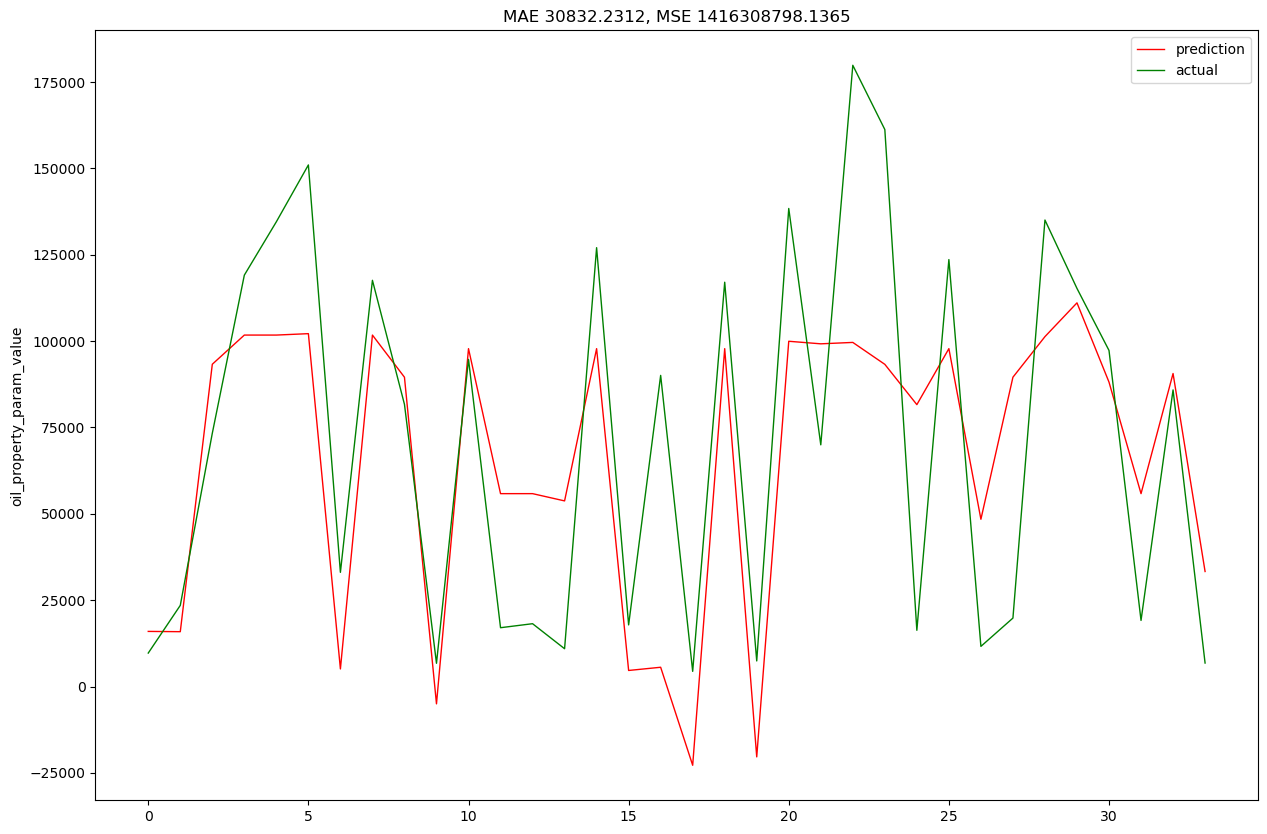

MAE score: 30832.2312
MSE score: 1416308798.1365


In [7]:
nn_model = SmallNN(X, y)
nn_model.fit_and_evaluate()


2024-04-20 04:47:10.557218: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-20 04:47:10.557291: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-20 04:47:10.557321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-HPESRLBL): /proc/driver/nvidia/version does not exist
2024-04-20 04:47:10.557686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
5/5 [==============================] - 19s 2s/step - loss: 0.9990 - val_loss: 1.0007 - lr: 0.0010
Epoch 2/20
5/5 [==============================] - 9s 2s/step - loss: 1.0122 - val_loss: 1.0005 - lr: 0.0010
Epoch 3/20
5/5 [==============================] - 9s 2s/step - loss: 1.0058 - val_loss: 1.0002 - lr: 0.0010
Epoch 4/20
5/5 [==============================] - 9s 2s/step - loss: 1.0026 - val_loss: 1.0000 - lr: 0.0010
Epoch 5/20
5/5 [==============================] - 10s 2s/step - loss: 1.0038 - val_loss: 0.9997 - lr: 0.0010
Epoch 6/20
5/5 [==============================] - 9s 2s/step - loss: 1.0030 - val_loss: 0.9997 - lr: 0.0010
Epoch 7/20
5/5 [==============================] - 9s 2s/step - loss: 1.0009 - val_loss: 0.9997 - lr: 0.0010
Epoch 8/20
5/5 [==============================] - 9s 2s/step - loss: 1.0024 - val_loss: 0.9996 - lr: 0.0010
Epoch 9/20
5/5 [==============================] - 9s 2s/step - loss: 1.0031 - val_loss: 0.9999 - lr: 0.0010
Epoch 10/20
5/5 [=========

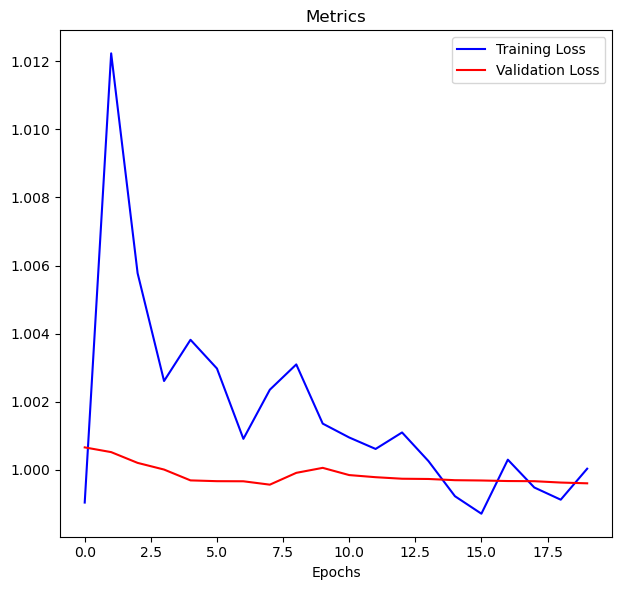

1/1 [==============================] - 3s 3s/step


In [5]:
scaler_ = StandardScaler() # RobustScaler
regressor = LstmRegressor(units=50, dropout_rate=0.2, optimizer='rmsprop', epochs=20, 
                          batch_size=64, neurons_1 = 128, neurons_2 = 64, scaler=scaler_)

X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42
        )
model, _ = regressor.fit(X_train, y_train, X_test, y_test)